notebook runnable in colab

In [ ]:
!git clone https://github.com/sosamandara/token_reduction_nlp.git

In [3]:
%cd /content/token_reduction_nlp

/content/token_reduction_nlp


In [4]:
!pip install datasets
import torch
import torch.nn as nn
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, GPT2Model, GPT2PreTrainedModel
from modeling_topK_gpt2 import CustomGPT2Attention, CustomGPT2Block, CustomGPT2Model, CustomGPT2LMHeadModel
from typing import Optional, Tuple, Union
import time
import json
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
from collections import defaultdict

In [5]:
# function to generate text
def generate_text(model, tokenizer, input_text, max_length=100):
    # tokenize the input text
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to('cuda')

    # generate text
    with torch.no_grad():
        output = model.generate(input_ids, max_length=max_length, pad_token_id=tokenizer.eos_token_id)

    # decode the generated text
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

In [6]:
dataset = load_dataset("ag_news")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [7]:
def run_generation_on_dataset(dataset,
                              model: GPT2LMHeadModel,
                              tokenizer: GPT2Tokenizer,
                              num_examples: int,
                              lengths: list,
                              model_name: str
                              ):
    results = []

    for idx in tqdm(range(num_examples), desc="Processing examples"):
        prefix = dataset["train"][idx]["text"]
        generated_text = dataset["train"][idx]["text"]

        for single_len in lengths:
            start = time.time()
            for i in range(single_len):
                generated_text = generate_text(model, tokenizer, generated_text, max_length=len(tokenizer(generated_text)["input_ids"])+1)

            end = time.time()


            result = {
                "example_index": idx,
                "lengths": single_len,
                "prefix": prefix,
                "generated_text": generated_text[len(prefix):],
                "time_taken": end - start
            }

            results.append(result)


    file_name = f'generation_results_{model_name}.json'
    with open(file_name, 'w') as f:
        json.dump(results, f, indent=4)

    return results

In [8]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
config = GPT2Config.from_pretrained(model_name)
model_gpt = GPT2LMHeadModel.from_pretrained(model_name, config=config)
model_gpt.to('cuda')

results = run_generation_on_dataset(dataset, model_gpt, tokenizer, 10, [10, 20, 30, 50, 100, 200, 300], "model_gpt_2")

#model_name = "gpt2"
#tokenizer = GPT2Tokenizer.from_pretrained(model_name)
#config = GPT2Config.from_pretrained(model_name)
#model = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                                                     layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
#model.to('cuda')
#
#results = run_generation_on_dataset(dataset, model, tokenizer, 10, [10, 20, 30, 50, 100], "model_gpt_2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing examples: 100%|██████████| 10/10 [06:09<00:00, 36.91s/it]


In [20]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
config = GPT2Config.from_pretrained(model_name)
custom_model = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=[0.0, 0.0, 0.2, 0.2, 0.2, 0.15, 0.2, 0.2, 0.05, 0.05, 0.0, 0.05],
                                                     layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
custom_model.to('cuda')

results = run_generation_on_dataset(dataset, custom_model, tokenizer, 10, [10, 20, 30, 50, 100, 200, 300], "custom_model")

Processing examples: 100%|██████████| 10/10 [04:03<00:00, 24.33s/it]


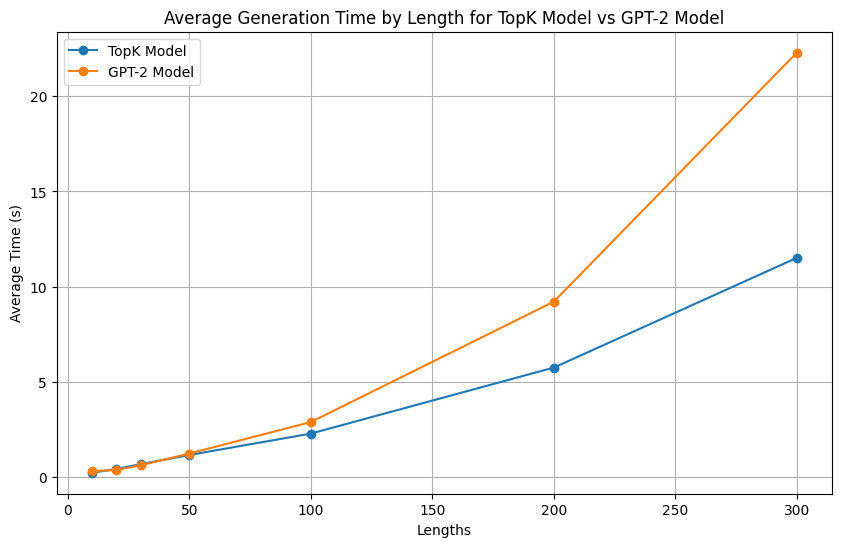

In [10]:
with open('generation_results_custom_model.json', 'r') as f:
    custom_model_results = json.load(f)

with open('generation_results_model_gpt_2.json', 'r') as f:
    gpt2_model_results = json.load(f)

def calculate_average_times(results):
    length_times = defaultdict(list)
    for result in results:
        length = result["lengths"]
        time_taken = result["time_taken"]
        length_times[length].append(time_taken)

    average_times = {length: sum(times) / len(times) for length, times in length_times.items()}
    return average_times

custom_model_avg_times = calculate_average_times(custom_model_results)
gpt2_model_avg_times = calculate_average_times(gpt2_model_results)

sorted_lengths = sorted(custom_model_avg_times.keys())

plt.figure(figsize=(10, 6))
plt.plot(sorted_lengths, [custom_model_avg_times[length] for length in sorted_lengths], label='TopK Model', marker='o')
plt.plot(sorted_lengths, [gpt2_model_avg_times[length] for length in sorted_lengths], label='GPT-2 Model', marker='o')
plt.xlabel('Lengths')
plt.ylabel('Average Time (s)')
plt.title('Average Generation Time by Length for TopK Model vs GPT-2 Model')
plt.legend()
plt.grid(True)
plt.show()
